In [1]:
# Importing the libraries we need
library(dplyr)
library(ggplot2)
library(scales)
library(stringr)
library(magrittr)
library(tidyverse)
library(purrr)
require(randomForest)
require(gbm)
require(plyr)
require(data.table)
# require(rhdfs)
# library(maps)
# library(mapproj)
# library(usdata)
# library(ggrepel)
# library(tidyverse)
# library(ggforce)
# library(ggthemes)
# library(usmap)
# devtools::install_github("UrbanInstitute/urbnmapr")
# library(urbnmapr)
# library(egg)
# library(treemapify)
# library(ggridges)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::extract()    masks magrittr::extract()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::set_names()  masks magrittr::set_names()

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘packa

In [2]:
cols = c('year', 'month', 'day', 'dow', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime','Carrier', 'FlightNum', 'TailNum', 
         'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 
         'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
         'LateAircraftDelay');
flt_2007 = read_csv('/kaggle/input/data-expo-2009-airline-on-time-data/2007.csv', cols)

print(dim(flt_2007))

Rows: 7453216 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (29): year, month, day, dow, DepTime, CRSDepTime, ArrTime, CRSArrTime, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 7453216      29


In [3]:
df1 = flt_2007[which(flt_2007$Origin == 'ORD' & !is.na(flt_2007$DepDelay)),]
df1$DepDelay = sapply(df1$DepDelay, function(x) (if (as.numeric(x)>=15) 1 else 0))

print(paste0("total flights: ", as.character(dim(df1)[1])))
print(paste0("total delays: ", as.character(sum(df1$DepDelay))))

[1] "total flights: 359169"
[1] "total delays: 109346"


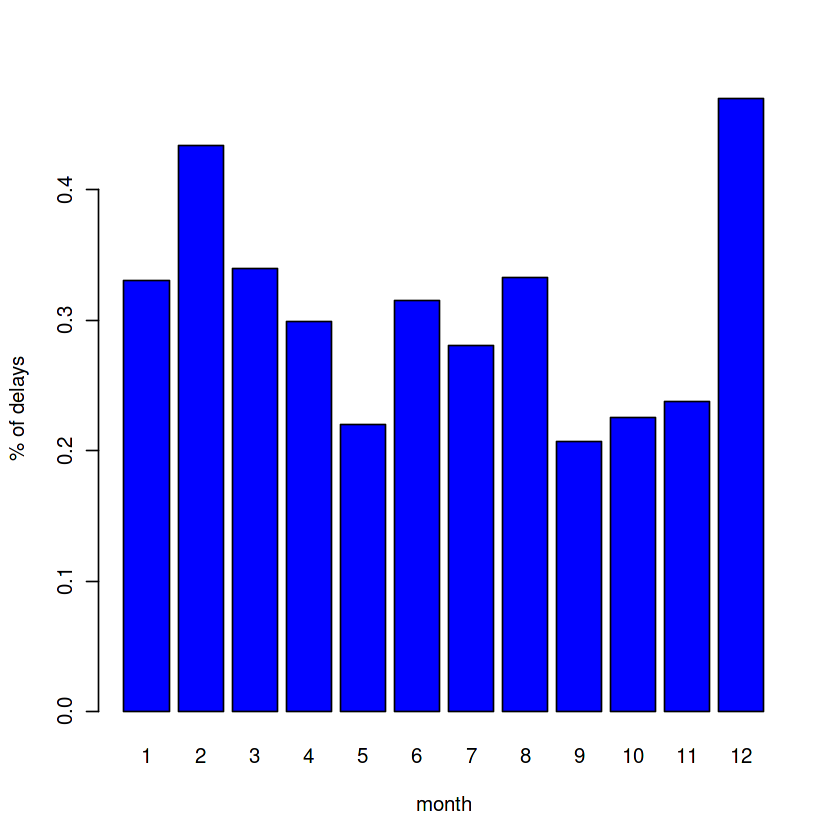

In [4]:
df2 = df1[, c('DepDelay', 'month'), with=F]
df2$month = as.numeric(df2$month)
df2 <- ddply(df2, .(month), summarise, mean_delay=mean(DepDelay))
barplot(df2$mean_delay, names.arg=df2$month, xlab="month", ylab="% of delays", col="blue")

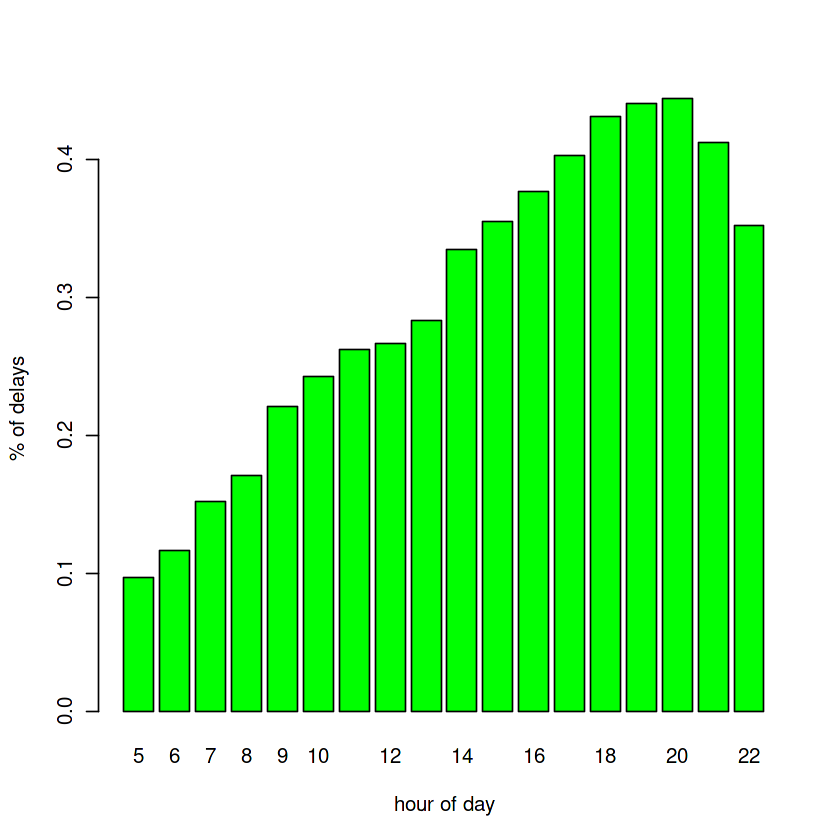

In [5]:
# Extract hour of day from 3 or 4 digit time-of-day string
get_hour <- function(x) { 
  s = sprintf("%04d", as.numeric(x))
  return(substr(s, 1, 2))
}

df2 = df1[, c('DepDelay', 'CRSDepTime'), with=F]
df2$hour = as.numeric(sapply(df2$CRSDepTime, get_hour))
df2$CRSDepTime <- NULL
df2 <- ddply(df2, .(hour), summarise, mean_delay=mean(DepDelay))
barplot(df2$mean_delay, names.arg=df2$hour, xlab="hour of day", ylab="% of delays", col="green")

In [6]:
# # Define the input and output schemas
# input_schema <- list(
#   Year = "character",
#   Month = "character",
#   DayofMonth = "character",
#   DayOfWeek = "character",
#   DepTime = "character",
#   CRSDepTime = "character",
#   DepDelay = "character",
#   Origin = "character",
#   Distance = "character",
#   Cancelled = "character"
# )
# output_schema <- list(
#   flight_date = "character",
#   y = "integer",
#   m = "integer",
#   dm = "integer",
#   dw = "integer",
#   crs = "integer",
#   dep = "integer",
#   dist = "integer"
# )

# # Define the holidays
# holidays <- c("01/01/2007", "01/15/2007", "02/19/2007", "05/28/2007", "06/07/2007", "07/04/2007",
#                "09/03/2007", "10/08/2007", "11/11/2007", "11/22/2007", "12/25/2007",
#                "01/01/2008", "01/21/2008", "02/18/2008", "05/22/2008", "05/26/2008", "07/04/2008",
#                "09/01/2008", "10/13/2008", "11/11/2008", "11/27/2008", "12/25/2008")

# # Define the functions
# get_hour <- function(deptime) {
#   paste0("%04d", deptime, 2)
# }

# to_date <- function(year, month, day) {
#   sprintf("%04d%02d%02d", year, month, day)
# }

# days_from_nearest_holiday <- function(year, month, day) {
#   sample_date <- as.Date(sprintf("%04d-%02d-%02d", year, month, day))

#   holidays %>% purrr::map_dbl(~abs(as.Date(.x) - sample_date)) %>% min()
# }

# # gen_features <- function(tuple) {
# #   {
# #     to_date(data$Year, data$Month, data$DayofMonth),
# #     data$DepDelay,
# #     data$Month,
# #     data$DayofMonth,
# #     data$DayOfWeek,
# #     get_hour(data$CRSDepTime),
# #     data$Distance,
# #     days_from_nearest_holiday(data$Year, data$Month, data$DayofMonth)
# #   }
# # }

# # Read the data
# data <- read.csv("/kaggle/input/data-expo-2009-airline-on-time-data/2007.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE) %>%
#   dplyr::select(one_of(names(input_schema)))

# # Filter the data
# # data <- data %>% filter(Origin == "ORD" & Cancelled == "0")

# # Generate the features
# features <- data %>% purrr::pmap({
#     to_date(data$Year, data$Month, data$DayofMonth);
#     data$DepDelay;
#     data$Month;
#     data$DayofMonth;
#     data$DayOfWeek;
#     get_hour(data$CRSDepTime);
#     data$Distance;
#     days_from_nearest_holiday(data$Year, data$Month, data$DayofMonth)
#   }, .default = NA)

# # Write the features to a file
# write.csv(features, "sample_2007.csv", row.names = FALSE)

In [7]:
# input_schema <- list(
#   Year = "character",
#   Month = "character",
#   DayofMonth = "character",
#   DayOfWeek = "character",
#   CRSDepTime = "character",
#   Origin = "character",
#   Dest = "character",
#   Distance = "character"
# )

# data <- read.csv("/kaggle/input/data-expo-2009-airline-on-time-data/2007.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE) %>%
#   dplyr::select(one_of(names(input_schema)))


In [8]:
# data$origin <- as.numeric(factor(data$Origin))
# data

In [9]:
# Function to compute Precision, Recall and F1-Measure
get_metrics <- function(predicted, actual) {
  tp = length(which(predicted == TRUE & actual == TRUE))
  tn = length(which(predicted == FALSE & actual == FALSE))
  fp = length(which(predicted == TRUE & actual == FALSE))
  fn = length(which(predicted == FALSE & actual == TRUE))

  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  F1 = 2*precision*recall / (precision+recall)
  accuracy = (tp+tn) / (tp+tn+fp+fn)
  
  v = c(precision, recall, F1, accuracy)
  v
}

# Read input files
process_dataset <- function(filename) {
  cols = c('Year', 'Month', 'DayofMonth', 'DayOfWeek',
           'CSRDepTime','DepDelay', 'Origin','Dest', 'Distance')
    
  data = read.csv(filename)
  data <- select(data, Year, Month, DayofMonth, DayOfWeek, CRSDepTime,DepDelay, Origin,Dest, Distance)
  data <- data %>% mutate(DepDelay = replace_na(DepDelay, 1000))
  data$DepDelay = as.factor(as.numeric(data$DepDelay) >= 15)
  data$Year = as.factor(data$Year)
  data$Month = as.factor(data$Month)
  data$DayofMonth = as.factor(data$DayofMonth)
  data$DayOfWeek = as.factor(data$DayOfWeek)
  data$Origin = as.integer(factor(data$Origin))
  data$Dest = as.integer(factor(data$Dest))
  data$CRSDepTime = as.numeric(data$CRSDepTime)
  data$Distance = as.numeric(data$Distance)
  data
}

# Prepare training set and test/validation set

data_2007 = process_dataset('/kaggle/input/data-expo-2009-airline-on-time-data/2007.csv')
data_2008 = process_dataset('/kaggle/input/data-expo-2009-airline-on-time-data/2007.csv')

train_y = data_2007$DepDelay
train_x = select(data_2007, Year, Month, DayofMonth, DayOfWeek, CRSDepTime, Origin,Dest, Distance)

test_y = data_2008$DepDelay
test_x = select(data_2008, Year, Month, DayofMonth, DayOfWeek, CRSDepTime, Origin,Dest, Distance)

In [10]:
length(train_y)

[1] 7453215

In [11]:
dim(train_x)

[1] 7453215       8

In [12]:
system.time({
    rf.model = randomForest(train_x, train_y, ntree=10)
rf.pr <- predict(rf.model, newdata=test_x)
m.rf = get_metrics(as.logical(rf.pr), as.logical(test_y))
print(sprintf("Random Forest: precision=%0.2f, recall=%0.2f, F1=%0.2f, accuracy=%0.2f", m.rf[1], m.rf[2], m.rf[3], m.rf[4]))
})

[1] "Random Forest: precision=0.84, recall=0.25, F1=0.38, accuracy=0.81"


   user  system elapsed 
387.934  14.101 402.082 

In [13]:
system.time({
train_x <- train_x %>% select(-Year)
test_x <- test_x %>% select(-Year)
gbm.model <- gbm.fit(train_x, as.numeric(train_y)-1, n.trees=300, verbose=F, shrinkage=0.01, distribution="bernoulli", 
                     interaction.depth=3, n.minobsinnode=30)
gbm.pr <- predict(gbm.model, newdata=test_x, n.trees= 300, type="response")
m.gbm = get_metrics(gbm.pr >= 0.4, as.logical(test_y))
print(sprintf("Gradient Boosted Machines: precision=%0.2f, recall=%0.2f, F1=%0.2f, accuracy=%0.2f", m.gbm[1], m.gbm[2], m.gbm[3], m.gbm[4]))
})

[1] "Gradient Boosted Machines: precision=0.53, recall=0.04, F1=0.08, accuracy=0.77"


    user   system  elapsed 
1953.496    5.462 1959.032 

In [14]:
t = 0
f = 0
for (i in test_y){
    if (i == TRUE){
        t = t+1
    }
    else{
        f = f +1
    }
}

t/(f+t)

[1] 0.2325282